# Задачи данного проекты:

- выбрать хотя бы два разных датасета (они могут быть и из компьютерного зрения, так и нет)
- выбрать хотя бы две метрики качества (одну внутреннюю NLL, а другую внешнюю - например, качество распознавания by 3rd-party classifier)
- пообучать генераторы с разным количеством шагов (хотя бы 3-5 значений)
- сгенерировать примеры на тесте - и здесь так же интересно - что если мы остановим генерировать раньше , чем последний шаг по времени, который был использован для обучения (т.е. исследование early stopping on inference)
- ну и посмотреть на подтипы guidance (например, задавать класс объектов) с учетом сказанного выше + интересно, как влияют разные стратегии управления дисперсией при генерации (процедуры эволюции альфа)

В итоге нужно будет предоставить код на своем гитхабе + детальный отчет о проделанной работе (в виде презентации), которую можно выложить там же.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST
from torchvision.datasets import CIFAR10, StanfordCars

import sys
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
sys.path.append('../')

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


# Read Dataset

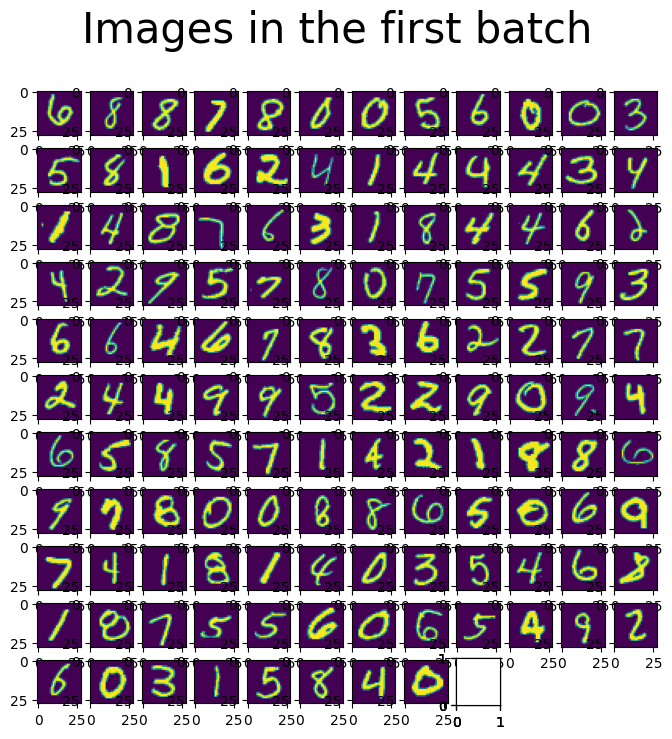

In [2]:
from utils import show_first_batch, transform_data_for_show

dataset = transform_data_for_show(MNIST)
train_dataloader = DataLoader(dataset, batch_size=128, num_workers=0, shuffle=True)
show_first_batch(train_dataloader)

In [3]:
image_channels = next(iter(train_dataloader))[0].size()[1]
image_channels

1

# Some visualization

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
from diffusion_models.ddpm import CustomDiffusionModel
from reverse_models.simple_unet.unet import CustomUnet
from reverse_models.unet.unet import Unet
from reverse_models.unet_1ch.unet import MyUnet



n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02
if image_channels == 1:
    unet = MyUnet()
else:
   unet = Unet(image_channels)
   
ddpm = CustomDiffusionModel(unet, n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

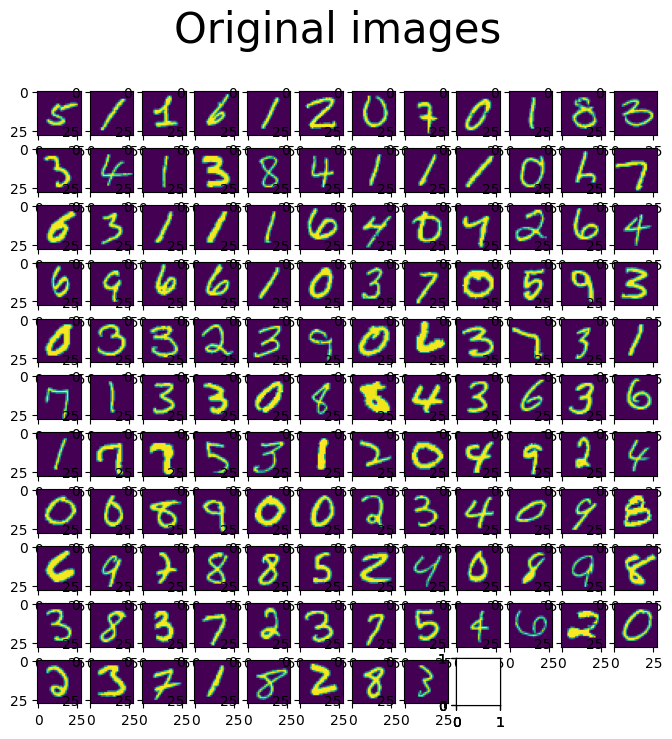

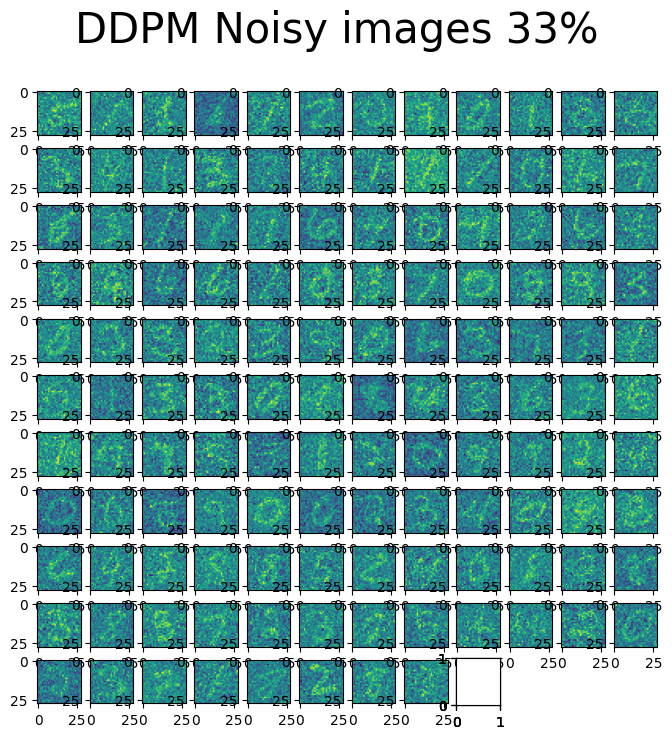

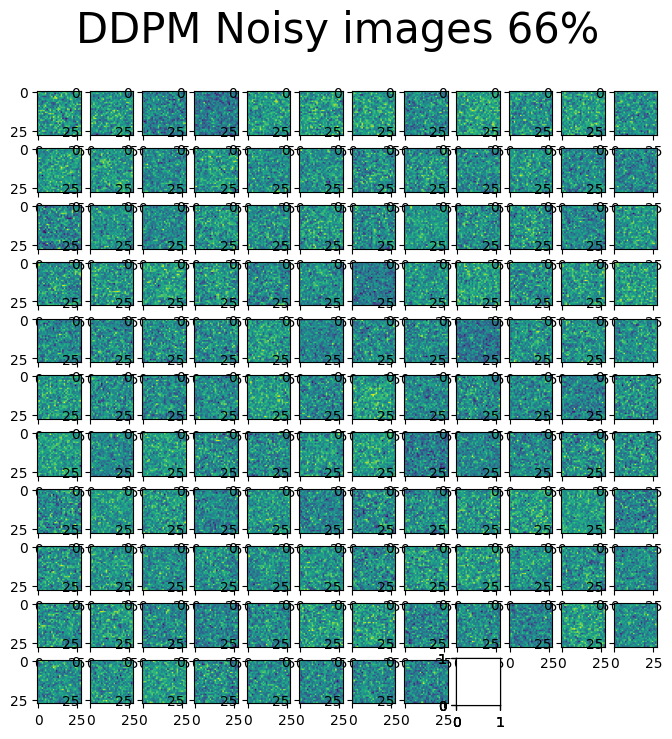

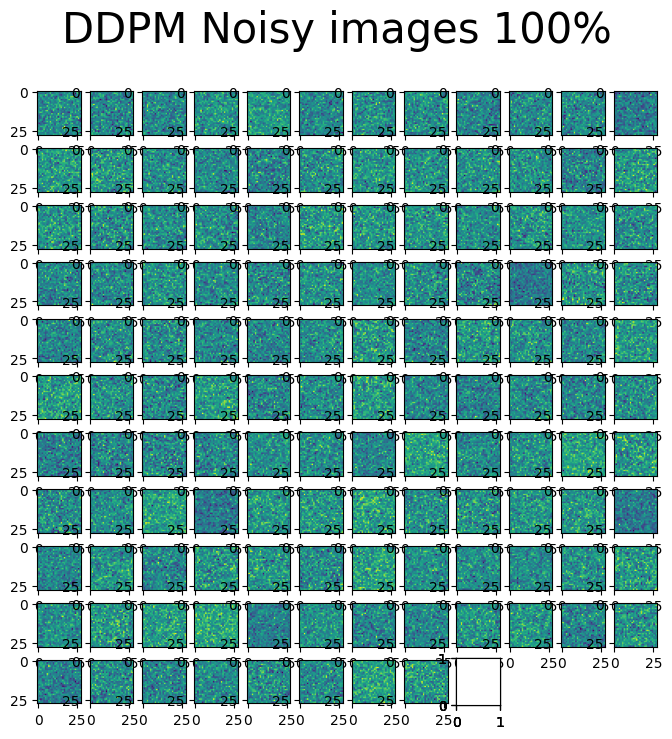

In [6]:
from utils import show_forward

show_forward(ddpm, train_dataloader, device)

# Training

In [7]:
from utils import training

optimizer = torch.optim.Adam(ddpm.parameters(), lr=0.001)     
training(ddpm, train_dataloader, n_epochs=1, device=device, optimizer=optimizer)        

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Testing

In [ ]:
store_path = './model_weights/ddpm.pt'

best_model = CustomDiffusionModel(Unet(image_channels), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")



In [ ]:
from utils import show_images, generate_new_images

print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name="./picture/fashion.gif"
    )
show_images(generated, "Final result")

In [ ]:
from IPython.display import Image

Image(open('fashion.gif', 'rb').read())